In [79]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
import cvxpy as cp
import copy
import time
import warnings
from scipy.linalg import solve_discrete_lyapunov, sqrtm

### Defining Various Functions

In [2]:
def schur_stable_decomposition(A):
    """
    Computes the strong stability parameters gamma and kappa for a given Schur-stable matrix A.
    """
    # Ensure A is a square matrix
    n = A.shape[0]
    spec_rad = np.max(np.abs(np.linalg.eigvals(A)))

    # We now solve to find a P that works for a scaled version of A. This ensures that the L for this scaled matrix has ||L||<1
    # and so the unscaled version has ||L||<1-\rho(A). 
    eps = 1e-3 # PArameter ensuring that the scaled matrix is still stable.
    A_scale = A/(spec_rad+eps)
    
    # Solve the Lyapunov equation A^T P A - P = -I for P
    Q = np.eye(n)  # Choose Q = I (any positive definite matrix works)
    P = solve_discrete_lyapunov(A_scale.T, Q)
    # print(A.T @ P @ A - P)
    # print(np.linalg.eigvals(P))
    # Ensure P is positive definite
    if not np.all(np.linalg.eigvals(P) > 0):
        raise ValueError("Matrix P is not positive definite.")
    
    # Compute H as a square root of P (here we use the principal square root).
    H = sqrtm(P)  
    
    # Compute L = H A H^{-1}
    H_inv = np.linalg.inv(H)
    L_scale = H @ A_scale @ H_inv         
    L = L_scale*(spec_rad+eps)

    
    # Compute gamma and kappa
    norm_L = np.linalg.norm(L, 2)
    gamma = 1 - norm_L
    kappa = np.linalg.norm(H, 2) * np.linalg.norm(H_inv, 2)
    # print(f'The spectral radius of A and L are is {spec_rad} and {np.max(np.abs(np.linalg.eigvals(L)))} respectively, and 2-norm of L is {norm_L}')
    # print(f'The 2-norm of L is {norm_L}')
    # print(f'A:{A} and L:{L} and HLH-inv:{H_inv@L@H}')
    return gamma, kappa

def state_bound(x0):
    """
    Computes an upper bound D on the state norm ||x_t|| for the system:
        x_{t+1} = A x_t + B u_t + w_t,
    given that:
        - ||u_t|| <= U,
        - ||w_t|| <= W,
        - ||A^k|| <= kappa * gamma^k for all k >= 0 (with 0 <= alpha < 1).
        - || B || <= kappa_B 
    are all pre defined global variables.
    
    Parameters:
    -----------
    x0 : np.ndarray
        Initial state of the system.
    
    Returns:
    --------
    D : float
        A uniform bound on ||x_t||, i.e., ||x_t|| <= D for all t.
    """
    
    # Compute the state bound D = (M/(1-alpha))*(||B||*U + W)
    D = kappa*np.linalg.norm(x0,2) +  (kappa / (1 - gamma)) * (kappa_B * U + W)
    return D

# Define quadratic costs that are not centered at the origin.
def cost(x, u, t):
    return (x - c_seq[t]).T @ Q_seq[t] @ (x - c_seq[t]) + u.T @ R_seq[t] @ u

# Gradient of cost w.r.t x, evaluated at a point x. 
def grad_c_x(x,t):
    return 2 * Q_seq[t] @ (x - c_seq[t])
    
# Gradient of cost w.r.t u, evaluated at a point u. 
def grad_c_u(u,t):
    return 2 * R_seq[t] @ u
    
# The ideal input and true input are identical when $K=0$.Needs to be changed if K\neq 0.
def ut(M_seq,t):
    H=len(M_seq)
    v=np.zeros(dim_u)
    for i in range(H): # This will take i from 0 to H-1. Need to input i+1 due to python indexing.
        # Updating the input to sum up feedforward from all past H disturbances. 
        if t-i-1<0:
            # print('I am feeding negative indices to w at i=',i)
            break # We consider all disturbances before t=0 to be 0.
        v+=M_seq[i] @ w[t-i-1] # Might cause a problem with negative indices need to fix this.
    return v

# The ideal state i.e. state as if we started from 0 at t-H and we use the same feedforward sequence over the past H steps.
# This is not the "actual" ideal state. But we define this function only to evaluate gradient of g w.r.t. M so we define this function 
# with constant M.
# The code for y[t] and the state update has been validated. IT can be shown that the difference between x[t] and y[t] is captured as A^{H+1} x[t-H-1] under constant M_seq.
def yt(M_seq,t):
    H=len(M_seq)
    y=np.zeros(dim_x)
    for j in range(H+1): # This will take j from 0 to H. This is what we need for y as defined in my overleaf note.
        if t-j-1<0:
            # print('I am feeding negative indices to w and u at i=',i)
            break # We consider all disturbances before t=0 to be 0.
        u = ut(M_seq,t-j-1)
        # if t<10:
        #     print("Feeding input",u," from",t-j-1,"to y at",t)
        y+=np.linalg.matrix_power(A,j) @ (w[t-j-1] + B @ u) # ut=vt for ideal state. 
        # if t<4:
        #     print('Adding w + Bu:', w[t-j-1] + B @ u, 'to y after discounting it by A',j,'times at',t)
    # print(y)
    return y

# Defining the projection operator required for implementing the OGD in Agarwal et al. 

def project_matrices(M_list):
    """
    Projects a list of matrices onto the set
      { {X^1, ..., X^H} | ||X^i||_2 <= K^3 * K_B * (1-gamma)^i, i=1,...,H },
    where ||.||_2 is the spectral norm (largest singular value). Both the 
    constraints and the objective do not have any coupling i.e. we could project each M^i
    to the set { X | ||X||_2 <= K^3 * K_B * (1-gamma)^i, i=1,...,H } but let us just 
    do it all together.

    Parameters:
      M_list : list of numpy arrays, each of shape (m, n), representing M^1, M^2, ..., M^H.
      K      : scalar parameter K.
      K_B    : scalar parameter K_B.
      gamma  : scalar parameter gamma.

    Returns:
      A list of numpy arrays corresponding to the projection of M_list onto the constraint set.
    """
    H = len(M_list)
    # Assume that all matrices have the same shape.
    m, n = M_list[0].shape

    # Create a cvxpy variable for each matrix.
    X_vars = [cp.Variable((m, n)) for _ in range(H)]

    # Objective: sum of squared Frobenius norms. Frobenius norm is the Euclidean norm for matrices. 
    objective = cp.Minimize(sum(cp.sum_squares(X_vars[i] - M_list[i]) for i in range(H)))

    # Constraints: for each matrix, its spectral norm must be bounded.
    constraints = []
    for i in range(H):
        # We use (i+1) because Python indexing is 0-based:
        bound = kappa * kappa_B * (1 - gamma)**(i+1)
        constraints.append(cp.norm(X_vars[i]) <= bound)  # The default norm for cp.norm is the spectral/2-norm. 

    # Set up and solve the problem.
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    # Return the projected matrices.
    return [X_vars[i].value for i in range(H)]

# Gradient of g_t. 

#####################################################################################################
# Agarwal et al. evaluate their gradient at the idea state and ideal input. 
# The ideal-input and true input are identical ofcourse because there is no liner feedback in ours.
# But the ideal state and true differ by: A^{H} x_{t-H}. Since A^t shrinks pretty quickly we will 
# ignore this difference. In fact assuming access to gradient at a point where the system isn't present 
# is a bit strange, but I suppose you can use the argument above to claim that the true gradient is a 
# resonable approximation.
#####################################################################################################
def grad_g(t):
    """
    This function takes as an input the t at which the gradient is computed. Then assuming that 
    cost function (Q[t],c[t],R[t]) and the state-input pair (x[t],u[t]) are global variables it 
    computes the gradient at the function g.

    Parameters:
      t      : time at which gradient is computed.
      
    Returns:
      A list of numpy matrix arrays corresponding to the gradient of g w.r.t. to the various matrices.
    """
    # H = len(M_list)
    
    grad_c_u = 2 * R_seq[t] @ u_A[t] 

    grad_c_x = 2 * Q_seq[t] @ (y_A[t]-c_seq[t])   

    # m, n = M_list[0].shape

    # Initialize a gradient for each matrix M^tau.
    grad_M = [np.zeros((dim_u,dim_x)) for _ in range(H)]
    
    for tau in range(H): # Goes from 0 to H-1 which is precisely the indexing for M's.
        if t-tau-1<0: # Note that if t-tau-1<0 then t-tau-h-2 is also negative for any h>=0. So we dont need to go into the next loop.
            break
        grad_M[tau] += np.outer(grad_c_u, w[t-tau-1])
        
        for h in range(H+1):  
            if t-tau-h-2<0: # Again just ensuring w for negative values do not show up.
                break
            grad_M[tau] += np.outer((np.linalg.matrix_power(A,h) @ B).T @ grad_c_x, w[t-tau-h-2])
    return grad_M

def project_and_invert(v):
    """
    This functions projects the vector v onto the set X^* = {(I-A)^{-1} B u | u in R^m}.
    It then computes the input u that generates the projected vector at steady state i.e. 
    
    u    S.T   B u = (I-A) proj(v)
        
    using the Moore-Penrose inverse of B defined as the global variable B_inv.
    
    Parameters:
        v (np.array): The vector (numpy array) in R^n to be projected.
        
    Returns:
        np.array: The input that leads to the projection of v onto X^* at steady state.
        
    Assumes:
        - Global variables A and B are defined.
        - A is an (n x n) numpy array, B is an (n x m) numpy array.
        - I-A is invertible.'
        - Crucially it assumes B is maximal rank.
    """
    
    # # Get the size of A (assumed to be square) and B.
    # n = A.shape[0]
    # m = B.shape[1]
    
    # Compute the inverse of I - A (we assume I-A is invertible).
    I = np.eye(dim_x)
    IA_inv = np.linalg.inv(I - A)
    
    # Define the matrix mapping from u to x in X^*
    X = IA_inv @ B
    
    # Define the CVXPY variable for u (u is in R^m)
    u = cp.Variable(dim_u)
    
    # The vector in the set X^* is given by X u.
    x_expr = X @ u
    
    # Define the objective: minimize the squared 2-norm of the difference.
    objective = cp.Minimize(cp.sum_squares(x_expr - v))
    
    # Set up and solve the problem.
    prob = cp.Problem(objective)
    prob.solve()

    return x_expr.value, u.value


# Setting up the system, cost functions and disturbances.

We randomly generate the system $(A,B)$ we will work with throughout this simulation. Crucially, we will assume that the system $A$ itself is stable.  This choice is w.l.o.g as discussed more in the paper. We will also define the learning landscape comprehensively i.e. we will define the learning horizon as well as the system dependent learning parameters (like $W$ (bound on disturbance), $U$ (norm bound on inputs) , $\kappa$ (norm bound on similarity transform matrix $H$), $\kappa_B$ (norm bound on $B$), $\gamma$ (degree of stability)). The system updates happen according to   

$$ x[t+1] = A x[t] + B u[t] + w[t]$$

where $w[t]$ denotes the sequence of adversarial disturbances. Let us now define the sequence of "adversarial" costs. For the purpose of this simulation we will assume that the costs are a quadratic function of the state and the input. However, we do not assume that quadratic functions are centered at the origin. We consider cost functions of the form 

$$ c_t(x,u) = (x-\bar x_t)^\intercal Q_t (x-\bar x_t)$$  

Due to the nature of the cost function it suffices to describe the sequence $Q_t$ and $\bar x_t$ to fully describe the sequence of cost functions. We also generate the sequence of disturbances $w_t$. We assume no control cost for simplicity but the extension to input dependent costs is straightforward.


### Intuition based things done in experimentation.
- I have tried to keep the length of $H$ small in Agarwal et al. approach's implementation. Their projected gradient step is very computationally expensive otherwise. I do this artificially by introducing a shrinking factor of $0.1$. 

In [120]:
# Problem setup
dim_x = 3  # State dimension
dim_u = 2  # Control dimension

# Define initial state. While this can be set to anything we will set it to zero. Some of the benchmarks are easier to compute with if we do this.
x0 = np.zeros(dim_x) 

# Generate stable A matrix
np.random.seed(42) # Cos ofcourse its the answer to life.
# A = np.random.randn(dim_x, dim_x)
A = np.array([[1,0.2,0.0]
              ,[0,1,0.2],
              [0.2,0,1]])

A /= 3*np.max(np.abs(np.linalg.eigvals(A)))  # Ensure stability
    
# Generate control matrix B
# B = np.random.randn(dim_x, dim_u)
B = np.array([[0,1.0],
              [0,0],
              [1,0]])

if np.linalg.matrix_rank(B)<dim_u:
    raise ValueError('The provided control matrix was not full rank.')

# Computing the Moore-Penrose inverse for B.
B_inv = np.linalg.inv(B.T @ B) @ B.T

# System parameters
gamma, kappa = schur_stable_decomposition(A)
kappa_B = LA.norm(B,2)

# Input and disturbance bound 
U = 3.0
W = 0.2

# Compute the bound D:
D = state_bound(x0)
# print("The state norm is bounded by D =", D)

# Print some representative values.
print('A:', A, '\n B:', B)
print('Gamma:',gamma,'kappa:', kappa,'kappa_B:', kappa_B)

### Initializing Simulation/Algorithm parameters

T = 1000  # Time horizon

# Memory horizon for Agarwal et. al's approach. Note that kappa for me is kappa^2 in Agarwal et al.  kappa = |H| |H_inv| for me. 
H = int(1/gamma*np.log(T*kappa))  # Long H's are extremely computationally expensive.So running it with short $T$ and large gamma

# Generate time-varying quadratic cost parameters
# Q_seq = [np.random.randn(dim_x, dim_x) for _ in range(T)]
Q_seq = [np.random.uniform(-1, 1, (dim_x, dim_x)) for _ in range(T)]
Q_seq = [Q.T @ Q for Q in Q_seq]  # Make each Q positive definite

c_seq = [np.random.uniform(size=dim_x) for _ in range(T)]  # Define nonzero c.
# c_seq = [np.ones(dim_x) for _ in range(T)]  # Define nonzero c.

# This next sequence has been included if we need to run simulations with input costs in the future. Set to 0 for now. 
R_seq = [np.random.randn(dim_u, dim_u) for _ in range(T)]
R_seq = [0 * R.T @ R for R in R_seq]  # Make each R positive definite. Hacky fix to make R zero for now.

# Compute the maximum norm across the sequences; For matrices:Frobenius norm; for vectors:2-norm.
max_norm_Q = max(np.linalg.norm(Q, ord='fro') for Q in Q_seq)
max_norm_c = max(np.linalg.norm(c, ord=2) for c in c_seq)

# # Lipshitz constant for cost function and bound on disturbance; needed for the learning parameter.
Gc = 2*max_norm_Q*(max_norm_c+D)

# Generate adversarial disturbances
w_seq = np.random.uniform(-1, 1, (T, dim_x))
max_norm_w = max(np.linalg.norm(w, ord=2) for w in w_seq)
w = W*w_seq/max_norm_w  # Normalize to unit norm

# Generate non-adversarial disturbance that are constant for debugging purposes. Manually generated for 3
# const_dist = np.array([-1.0,1.0,2.0])   
# w_seq = np.tile(const_dist, (T, 1))
# max_norm_w = max(np.linalg.norm(w, ord=2) for w in w_seq)
# w = W*w_seq/max_norm_w  # Normalize to unit norm

print('Q_seq[0]:',Q_seq[0],'\n c_seq[0]:',c_seq[0],'\n w[0]:',w[0], 'H:',H)
print(f'Q_bd:{max_norm_Q}, c_bd:{max_norm_c}, D:{D}')

A: [[0.27777778 0.05555556 0.        ]
 [0.         0.27777778 0.05555556]
 [0.05555556 0.         0.27777778]] 
 B: [[0. 1.]
 [0. 0.]
 [1. 0.]]
Gamma: 0.6666666666666667 kappa: 8.386920399869865 kappa_B: 1.0
Q_seq[0]: [[0.85238751 0.2895334  0.72852188]
 [0.2895334  0.15249811 0.11063367]
 [0.72852188 0.11063367 1.52447213]] 
 c_seq[0]: [0.40937279 0.94429991 0.80532075] 
 w[0]: [ 0.12264872 -0.09234202  0.11147135] H: 13
Q_bd:5.8768679472958265, c_bd:1.6424675074462785, D:80.51443583875073


In [126]:
# Initialize system state. This defaults initial state to origin.
x_H = np.zeros((T+1, dim_x))     # States generated by Hebbar algo
x_A = np.zeros((T+1, dim_x))     # States generated by Agarwal algo
x_d = np.zeros((T+1, dim_x))     # States generated under no inputs. This is for defining benchamrks later.

y_A = np.zeros((T+1, dim_x))       # Ideal states required for Agarwal algo
z = np.zeros((T+1, dim_x))       # Equilibrium states required for Hebbar algo 

u_H = np.zeros((T, dim_u))       # Inputs generated by Hebbar algo
u_A = np.zeros((T, dim_u))       # Inputs generated by Agarwal algo

cumulative_cost_A = np.zeros(T)    # Cumulative cost by Agarwal algo
cumulative_cost_H = np.zeros(T)    # Cumulative cost by Hebbar algo
cumulative_cost_d = np.zeros(T)    # Cumulative cost under no input, just for lols.

GD_check = np.zeros(T)

# Learning parameter inversely proportional to \sqrt{G_c W T}   
eta_A = 10*(T)**(-0.5)/Gc/W                # Agarwal's learning rate with a factor of 10 included.
print('Crude Learning rate Agarwal:',eta_A)

# We pick our learning rate.
eta_H = 5*2*D*gamma/(Gc*T**(0.5)*(1+4*kappa**2)**0.5) # Our learning rate with a factor of 10.
print('Crude Learning rate Hebbar:',eta_H) 

# Some tuning parameters for the simulation. Reset to defaults to run the un-hacked code.
# Define a random starting feedforward sequence within the \cM as well as a dummy variable to 
# store next controller sequence.
M_seq = [kappa*kappa_B*(1-gamma)**(i+1)*np.random.uniform(size=(dim_u,dim_x)) for i in range(H)]
M_next = [np.zeros((dim_u, dim_x)) for _ in range(H)]

# Record the start time
start_time = time.time()

# Placeholder: Loop over T steps to update state using chosen control inputs
for t in range(T):
    # Compute control input u_t using the disturbance feedforward law.
    u_A[t] = ut(M_seq,t)  

    # Computing the projection of the tracked point as well as the input that sends us there.
    z[t],u_H[t] = project_and_invert(z[t]) 
    
    # Update next state using the input and disturbance.
    x_H[t+1] = A @ x_H[t] + B @ u_H[t] + w[t]  
    x_A[t+1] = A @ x_A[t] + B @ u_A[t] + w[t] 
    
    # Generating the sequence of state solely affected by disturbances. We need this for generating nominal costs and benchmarks.
    x_d[t+1] = A @ x_A[t] + w[t] 
    
    # Incur cost at current state and for taking the current input. 
    cumulative_cost_A[t] = cost(x_A[t], u_A[t], t) + (cumulative_cost_A[t-1] if t > 0 else 0)
    cumulative_cost_H[t] = cost(x_H[t], u_H[t], t) + (cumulative_cost_H[t-1] if t > 0 else 0)
    cumulative_cost_d[t] = cost(x_d[t], np.zeros(dim_u), t) + (cumulative_cost_d[t-1] if t > 0 else 0)
    
    ##### Update for Hebbar algo #############
    z[t+1] = z[t] - eta_H*grad_c_x(x_H[t],t)
    ##########################################
    
    ##### Update for Agarwal algo ############
    # Recalling that g_t(M) = f_t(M,...,M) = c_t(y(M,dots,M), u(M,...,M)) we update y[t+1] for the next 
    # round using the observed w[t]. 
    y_A[t+1] = yt(M_seq,t+1)    # Does not depend on any future disturbances and assumes it is the same M_seq at all time steps.
    
    # Compute the gradient of g at the current time step.
    nabla_t = grad_g(t)
    
    # Gradient descent step to update M_seq followed by projection.
    for h in range(H):
        M_next[h]=M_seq[h]-eta_A*nabla_t[h]
    
    M_next = project_matrices(M_next) 

    # Checking if gradient descent actually descends. This is for sanity check.
    og_cost = cost(yt(M_seq,t), ut(M_seq,t), t)         # Computing g_t(M_prev)
    updated_cost = cost(yt(M_next,t), ut(M_next,t), t)  # Computing g_t(M_next)
    GD_check[t] = og_cost - updated_cost
    
    # Preparing feedforward for the next round.
    M_seq = copy.deepcopy(M_next)
    ##########################################

# Record the end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds for {T} length horizon.")

Crude Learning rate Agarwal: 0.001637382011697947
Crude Learning rate Hebbar: 0.0010460671997873522
Elapsed time: 64.866116 seconds for 1000 length horizon.


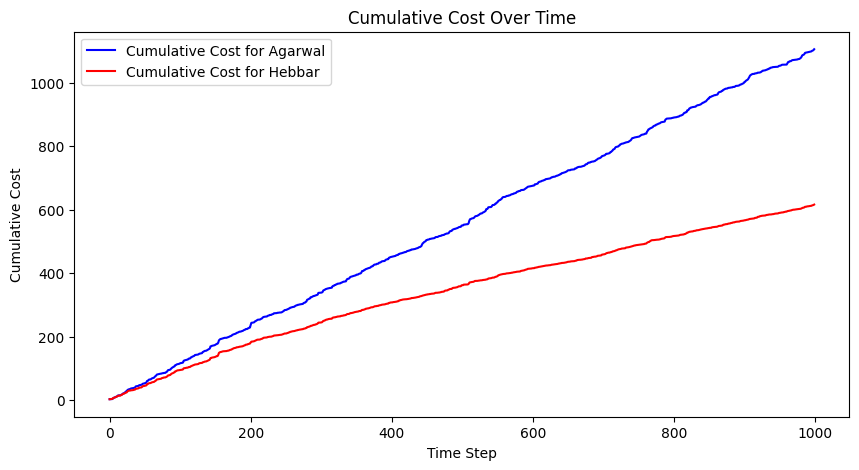

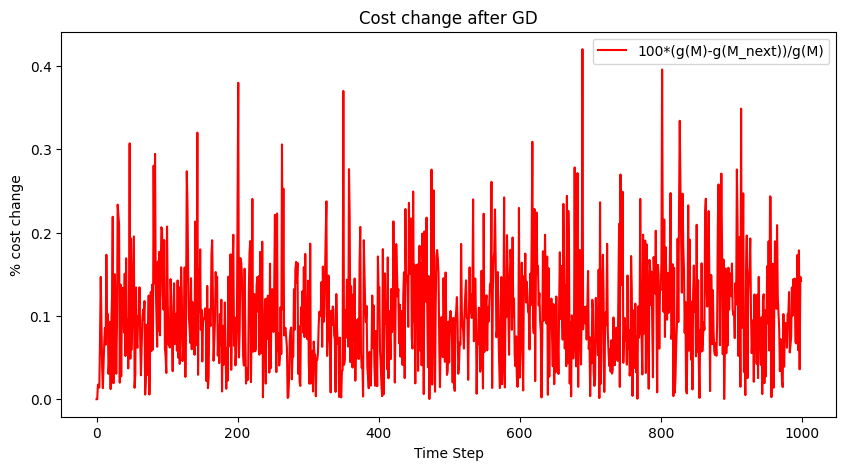

In [127]:
# Plot cumulative cost over time
plt.figure(figsize=(10, 5))
plt.plot(range(T), cumulative_cost_A, label="Cumulative Cost for Agarwal", color='b')
plt.plot(range(T), cumulative_cost_H, label="Cumulative Cost for Hebbar", color='r')
# plt.plot(range(T), cumulative_cost_d, label="Cumulative Cost w/o input", color='g')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Cost")
plt.title("Cumulative Cost Over Time")
plt.legend()
plt.show()

# Plot normalized change in cost after GD step over time
plt.figure(figsize=(10, 5))
plt.plot(range(T), [100*GD_check[t]/cost(x_A[t],u_A[t],t) for t in range(T)], label="100*(g(M)-g(M_next))/g(M)", color='r')
plt.xlabel("Time Step")
plt.ylabel("% cost change")
plt.title("Cost change after GD")
plt.legend()
plt.show()

# # Plotting cost incurred in every step.
# plt.figure(figsize=(10, 5))
# plt.plot(range(T), [cost(x[t],u[t],t) for t in range(T)], label="Cost", color='r')
# plt.xlabel("Time Step")
# plt.ylabel("Cost")
# plt.title("Cost at every time step.")
# plt.legend()
# plt.show()

# Plot states over time
# plt.figure(figsize=(10, 5))
# plt.plot(range(T+1), x_H, label=['x1','x2','x3'])
# # plt.plot(range(500), y[:500], label=['y1','y2','y3'])
# plt.xlabel("Time Step")
# plt.ylabel("States")
# plt.title("States generated by Hebbar algo.")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(range(T+1), x_A, label=['x1','x2','x3'])
# # plt.plot(range(500), y[:500], label=['y1','y2','y3'])
# plt.xlabel("Time Step")
# plt.ylabel("States")
# plt.title("States generated by Agarwal algo.")
# plt.legend()
# plt.show()

# # Plot states over time
# plt.figure(figsize=(10, 5))
# plt.plot(range(T),  c_seq, label=['x1','x2','x3'])
# # plt.plot(range(500), y[:500], label=['y1','y2','y3'])
# plt.xlabel("Time Step")
# plt.ylabel("Tracked States")
# plt.title("Tracked States Over Time")
# plt.legend()
# plt.show()

### Comparing with the benchmark

We will compare the experimental results we obtain here with a few different benchmarks.

1) **Best fixed point** - This is the theoretical benchmark I propose in my work. At every time $t$ I will compute the input $u_t \in \mathcal{U}$ that gives me minimum cumulative payoff if we spent all time there. Since the cost functions are convex and the simulations are run assuming there are no bounds on input (set of reachable states is unbounded), the mimima is attained at the point where gradient of the sum is $0$ i.e. $x$ such that $\nabla_x \sum_{t} f_t(x) = 0$. Also recall that to do so we can use the equivalent nominal costs to compute the this best in hindsigh input. 

2) **Best disturbance feedforward** - This is the true benchmark that the Agarwal work compares to. They show that the cost incurred by on specific instance of such a controller is close that of the best linear controller in hindsight. And then they argue that there is no loss of generality in considering this class. The advantage with this benchmark is that the cost functions are convex w.r.t to such feedforward controller matrices and so computing this benchmark ie easier. But it is not the true benchmark Agarwal compares to.

3) **Optimal Clarivoyant Controller** - This is to be done, it can be computed analytically and is done in another file.

In [128]:
# 1 - Best fixed input
### Computing the best fixed point to stabilize to. Like I did when implementing my controller, 
# We will ignore the disturbance by changing the c_seq to be offset by x_d^t.  

def BIH_fixed_point(t):
    """
    This function takes as an input a single time parameter and computes the state (and the input that would have brought us to this state.) 
    that would have been the best to stabilize given all the cost functions up until that time. Basically it computes

        minimize_{x in {(I-A)^{-1} B u | u in R^M}}  sum_{tau=0}^{t} (x - x_seq[tau])^T Q_seq[tau] (x - x_seq[tau])
    
    Input:
        t (int): The time index (sum is over tau = 0, ..., t-1).
        
    Output:
        x_star (array): The optimal state x*.
        u_star (array): The optimal inpute u*.
    """
    # Mapping from u to x.
    M = np.linalg.inv(np.eye(dim_x) - A) @ B

    if t==0:
        u = np.random.randn(dim_u)
        return M @ u, u
        
    # Initialize the accumulators for the sums:
    # P = sum_{tau=0}^{t} M^T Q_tau M 
    # q = sum_{tau=0}^{t} M^T Q_tau c_seq[tau]  (an M-dimensional vector)
    P = np.zeros((dim_u, dim_u))
    q = np.zeros(dim_u)
    
    for tau in range(t):
        Q_tau = Q_seq[tau]
        c_tau = bar_c_seq[tau]
        P += M.T @ Q_tau @ M
        q += M.T @ Q_tau @ c_tau
        
    # Solve for the optimal u: P * u_star = q.
    u_star = np.linalg.solve(P, q)
    
    # Recover the optimal x: x_star = X * u_star.
    x_star = M @ u_star

    if(LA.norm(u_star)>U):
        warnings.warn(f"The input magnitude is out of bounds. || u || = {LA.norm(u_star)}, u = {u_star}")
    return x_star, u_star
 
# Create vector for storing cumulative costs until any time under BIH.
cumu_cost_until_t = np.zeros(T)

# Record the start time
start_time = time.time()

# Generating nominal costs by offseting the tracking target. 
bar_c_seq = c_seq - x_d[:-1]  # Recall that we do not have any terminal cost.

# Placeholder: Loop over T steps to update state using chosen control inputs
for t in range(T):
    # Compute control input u_t using the disturbance feedforward law.
    BIH_u = BIH_fixed_point(t)[1]  

    # Reset states and costs.
    x_benchmark = np.zeros((T+1, dim_x))    
    cumulative_cost = 0.0
    
    # Compute the best in hindsight cost with a fixed input. Recall that we are not accounting for any disturbances  
    for tau in range(t+1): 
        # Update next state using the input and disturbance.
        x_benchmark[tau+1] = A @ x_benchmark[tau] + B @ BIH_u + w[tau]  
        
        # Incur cost at current state and for taking the current input. 
        cumulative_cost += cost(x_benchmark[tau], BIH_u, tau)
    
    cumu_cost_until_t[t]=cumulative_cost

# Record the end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds for {T} length horizon.")
# BIH_fixed_point(10)[0]/BIH_fixed_point(10)[1], np.linalg.inv(np.eye(dim_x) - A) @ B

Elapsed time: 10.003030 seconds for 1000 length horizon.


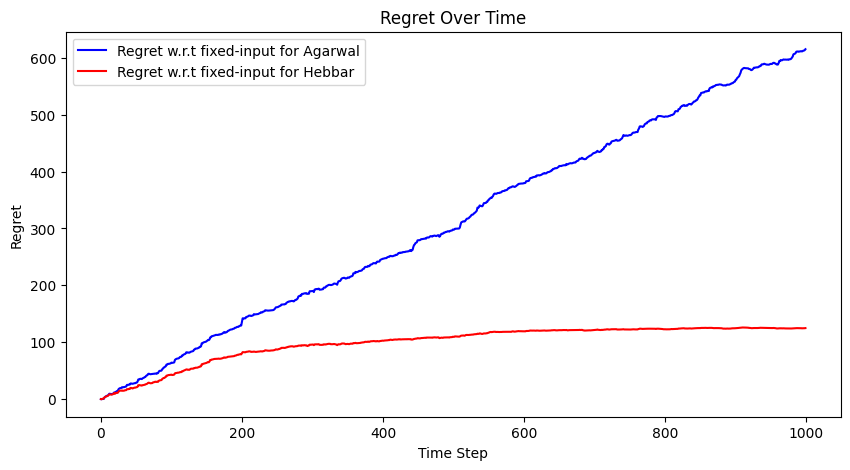

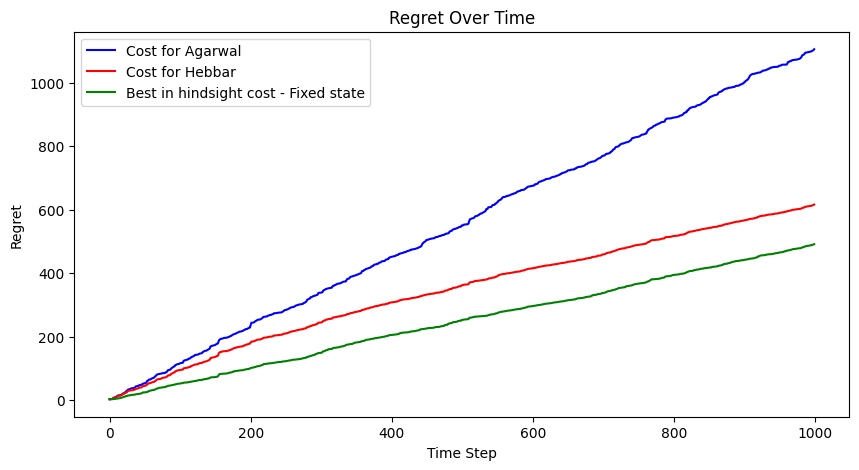

In [129]:
plt.figure(figsize=(10, 5))
plt.plot(range(T), cumulative_cost_A-cumu_cost_until_t, label="Regret w.r.t fixed-input for Agarwal", color='b')
plt.plot(range(T), cumulative_cost_H-cumu_cost_until_t, label="Regret w.r.t fixed-input for Hebbar", color='r')
# plt.plot(range(T), cumu_cost_until_t, label="Best in hindsight cost - Fixed state", color='g')
plt.xlabel("Time Step")
plt.ylabel("Regret")
plt.title("Regret Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(T), cumulative_cost_A, label="Cost for Agarwal", color='b')
plt.plot(range(T), cumulative_cost_H, label="Cost for Hebbar", color='r')
plt.plot(range(T), cumu_cost_until_t, label="Best in hindsight cost - Fixed state", color='g')
plt.xlabel("Time Step")
plt.ylabel("Regret")
plt.title("Regret Over Time")
plt.legend()
plt.show()

In [27]:
## 2 - Best DAC policy - Defining some required functions. 

def compute_Phi_list(T):
    """
    Computes a list of Phi_t matrices for t=1,...,T.
    
    For each time step t (1-indexed) we express:
        vec(x_t) = Phi_{t-1} * m,
    where x_t is produced by the DAC policy applied from time 0 onward
    with x_0 = 0. Here,
        Phi_t = [Phi_{t,1}  Phi_{t,2}  ...  Phi_{t,H}],
    with for each block (for j=1,...,H):
        Phi_{t,j} = sum_{k=0}^{t-j} (w_k^T ⊗ A^(t-(k+j)) B).
    
    We compute these blocks recursively:
    
    For each fixed block j (with 1-indexing; in code j=1,...,H):
      - For t = j:   Phi_{t,j} = w_0^T ⊗ B.
      - For t >= j+1:  Phi_{t,j} = (I ⊗ A) * Phi_{t-1,j} + (w_{t-j}^T ⊗ B).
      
    ******************************************************************************************************
    **** I did some weird things with indexes but it works now and i don't have time to "fix" it.     ****
    ****                      So if it is confusing go figure :')                                     ****
    **** But basically x_2 = A x_1 + B u_ 1 = phi_1 @ m = phi_block[0][0] @ m[:dim_x*dim_u]          ****
    ******************************************************************************************************
    
    Returns:
        Phi_list: list of length T, where Phi_list[t-1] is the matrix Phi_t (of shape (dim_x, H*(dim_x*dim_u))).
    """
    n = dim_x   # state dimension
    m = dim_u   # input dimension
    
    # Prepare a 2D list to hold Phi_{t,j} for t=1,...,T and j=1,...,H.
    # We'll store phi_blocks[t-1][j-1] corresponding to Phi_{t,j} (with t in 1-indexing).
    phi_blocks = [[np.zeros((n, n * m)) for _ in range(H)] for _ in range(T)]
    
    # For each time step t = 1,...,T (we use Python index t_index = t-1)
    for t in range(1, T+1):
        for j in range(1,H+1):
            # The block for DAC parameter j is active only when t >= j+1.
            if t < j:
                # Not active; leave as zeros.
                continue
            elif t == j:
                # Base case: t = j -> Phi_{j, j} = w_0^T ⊗ B.
                # print(phi_blocks[t-1][j-1].shape, np.kron(w[0].reshape(1, n), B).shape)
                phi_blocks[t-1][j-1] = np.kron(w[0].reshape(1, n), B)
            else:
                # For t >= j+2, use recursion:
                # Phi_{t,j} = (I ⊗ A) * Phi_{t-1,j} + (w_{t-j-1}^T ⊗ B)
                # (Here t-1 is in 1-indexed time, so we use index t-2 in our list for Phi_{t-1,j}.)
                prev_phi = phi_blocks[t-2][j-1]  # Phi_{t-1,j}
                updated_phi = A @ prev_phi
                # New term: we want to add (w_{t-j-1}^T ⊗ B).
                # Here, t-j-1 is guaranteed to be >= 1 since t >= j+2.
                w_index = t - j  # in 1-indexed time, so use w[w_index-1] if w[0] corresponds to w_0.
                # Our convention: w[0] is w_0, w[1] is w_1, etc.
                w_vec = w[w_index]  # shape (n,)
                new_term = np.kron(w_vec.reshape(1, n), B)
                phi_blocks[t-1][j-1] = updated_phi + new_term
    
    # Now stack the H blocks horizontally for each t to form Phi_t. 
    Phi_list = []
    for t in range(T):
        Phi_t = np.hstack(phi_blocks[t])  # shape (n, H*(n*m))
        Phi_list.append(Phi_t)
    return Phi_list

def vectorize_M(M_list):
    """
    Given a list of H matrices M_list = [M^[0], ..., M^[H-1]] (each of shape (dim_u, dim_x)),
    vectorizes them into a single vector m by stacking the columns of the matrix in order. 
    
    Returns:
        m: a numpy array of shape (H * dim_u * dim_x,).
    """
    m_list = [M.reshape(-1, 1,order='F') for M in M_list]
    m = np.vstack(m_list).flatten()
    return m

def unvectorize_M(m):
    """
    Given a vector m of length H * dim_u * dim_x (obtained by stacking the columns of H matrices),
    unvectorize it into a list of H matrices, each of shape (dim_u, dim_x), using column-stacking.
    
    Parameters:
        m     : numpy array of shape (H*dim_u*dim_x,)
        
    Returns:
        M_list: list of H numpy arrays, each of shape (dim_u, dim_x)
    """
    block_size = dim_u * dim_x
    M_list = []
    for j in range(H):
        block = m[j*block_size:(j+1)*block_size]
        M_j = np.reshape(block, (dim_u, dim_x), order='F')
        M_list.append(M_j)
    return M_list

# ========= Testing the generation of states by this phi function. =========
# # Define a DAC policy: list of H matrices (each of shape (dim_u, dim_x))
# M_list = [np.ones([dim_u, dim_x]) for _ in range(H)]
# M_list = [(h+1)*np.ones([dim_u, dim_x]) for h in range(H)]

# M_list = [np.random.randn(dim_u, dim_x) for _ in range(H)]

# # Vectorize DAC parameters
# m = vectorize_M(M_list)

# # Compute state trajectory using our DAC representation (x_0=0)
# Phi_list = compute_Phi_list(T)
# x_list = []
# x_list.append(np.zeros(dim_x))
# for t in range(1,5):
#     x_t = Phi_list[t-1] @ m  # x_t is (dim_x,)
#     x_list.append(x_t)

# print(x_list)

# x_list_classic = []
# x_test=np.zeros(dim_x)
# for t in range(5):
#     x_test = A @ x_test + B @ ut(M_list,t)  
#     x_list_classic.append(x_test)

# print(x_list_classic)

# Testing the vectorize and unvectorize functions.
# print(all(np.allclose(M_doubleInvert, M) for M_doubleInvert, M in zip(unvectorize_M(vectorize_M(M_list)), M_list)))

# Other things I used in testing

In [28]:
def solve_incremental_cost(T_max, Phi_list):
    """
    Incrementally solves for the optimal DAC parameter vector m (subject to ||m||_2 <= 1)
    that minimizes the cumulative cost
      J_T(m) = sum_{t=1}^T (Phi_{t-1} m - c_t)^T Q_t (Phi_{t-1} m - c_t)
    which can be rewritten as
      J_T(m) = m^T Q_total(T) m - 2 b_total(T)^T m + const(T),
    where
      Q_total(T) = sum_{t=1}^T Phi_{t-1}^T Q_seq[t] Phi_{t-1},
      b_total(T)  = sum_{t=1}^T Phi_{t-1}^T Q_seq[t] c_seq[t],
      const(T)    = sum_{t=1}^T c_seq[t-1]^T Q_seq[t-1] c_seq[t-1].
      
    We update these cumulatively and warm-start each optimization using the previous optimal solution.
    
    Returns:
         costs: list of optimal cumulative costs for T=1,...,T_max.
         m_values: list of optimal m vectors for T=1,...,T_max.
    """
    d_m = H * dim_u * dim_x  # dimension of m
    Q_total = np.zeros((d_m, d_m))
    b_total = np.zeros((d_m, 1))
    const_total = 0.0
    costs = []
    m_values = []
    m_prev = None  # for warm start

    # x_0, x_1 are both 0 if we assume x_0 = 0. Because u_1 = 0 
    for t in range(2, T_max):
        Phi_t = Phi_list[t-2]  # shape (dim_x, d_m)
        Q_total += Phi_t.T @ Q_seq[t] @ Phi_t # We are actually using Phi_list[0] when i am refering to phi_2 
        # print(f't={t} and smallest eigenvalues of Q_tot is: \n {np.min(np.linalg.eig(Q_total)[0])}')
        b_total += Phi_t.T @ Q_seq[t] @ bar_c_seq[t].reshape(-1, 1)
        const_total += bar_c_seq[t].T @ Q_seq[t] @ bar_c_seq[t]
        
        m_var = cp.Variable(d_m)
        constraints = []
        for i in range(H):
            # Reshape the appropriate block of m
            M_i = cp.reshape(m_var[i*dim_u*dim_x:(i+1)*dim_u*dim_x], (dim_u, dim_x), order='F')
            constraints.append(cp.norm(M_i, 2) <= kappa * kappa_B * (1 - gamma)**(i+1))
        
        cost_expr = cp.quad_form(m_var, cp.psd_wrap(Q_total)) - 2 * (b_total.T @ m_var)
        problem = cp.Problem(cp.Minimize(cost_expr), constraints)
        
        if m_prev is not None:
            m_var.value = m_prev  # use previous solution as warm start
        
        problem.solve(solver=cp.SCS, warm_start=True, verbose=False)
        m_prev = m_var.value  # store optimal solution for warm start in next iteration
        
        opt_cost = problem.value + const_total
        costs.append(opt_cost)
        m_values.append(m_var.value)
        
    return costs, m_values

# ------------------ Main Script ------------------
# if __name__ == "__main__":

# Generating nominal costs by offseting the tracking target. 
bar_c_seq = c_seq - x_d[:-1]  # Recall that we do not have any terminal cost.

# Compute Phi_list for T_max time steps.
Phi_list = compute_Phi_list(T)

start_time = time.time()
# Solve the incremental quadratic program with warm start.
costs, m_values = solve_incremental_cost(T, Phi_list)

# Record the end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds for {T} length horizon.")

Elapsed time: 46.446990 seconds for 1000 length horizon.


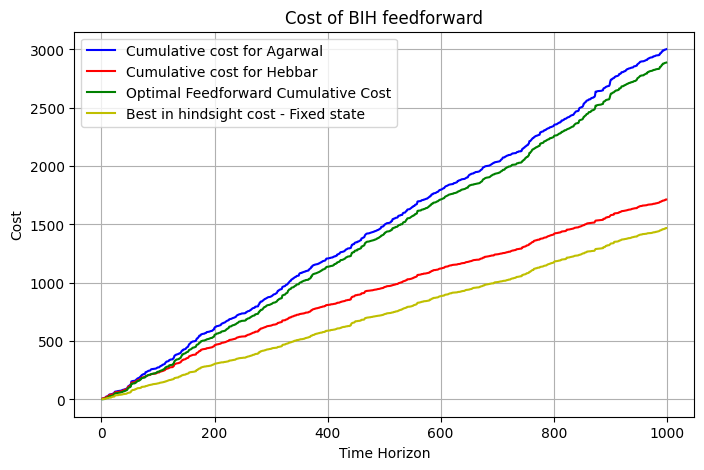

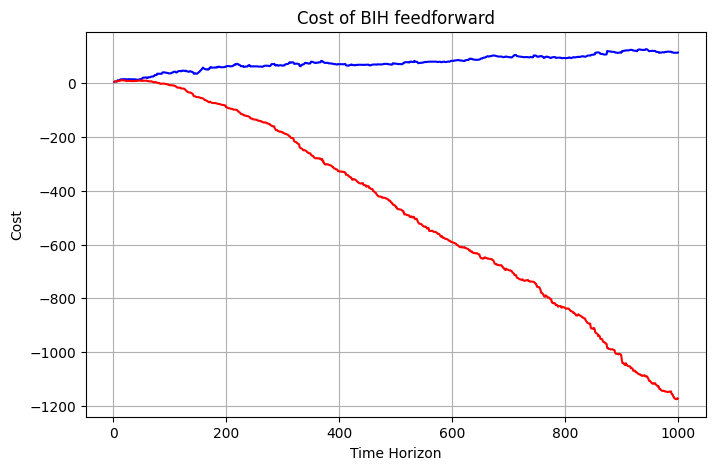

In [64]:
# ---------------------------
# Plotting the optimal values across time
# ---------------------------
# Plot the optimal cumulative cost vs. time horizon
plt.figure(figsize=(8, 5))
Ts = np.arange(2, T)
plt.plot(Ts, cumulative_cost_A[2:T], label="Cumulative cost for Agarwal", color='b')
plt.plot(Ts, cumulative_cost_H[2:T], label="Cumulative cost for Hebbar", color='r')
plt.plot(Ts, costs, label='Optimal Feedforward Cumulative Cost', color='g')
plt.plot(Ts, cumu_cost_until_t[2:T], label="Best in hindsight cost - Fixed state", color='y')
plt.xlabel("Time Horizon")
plt.ylabel("Cost")
plt.title("Cost of BIH feedforward")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(Ts, cumulative_cost_A[2:T]-costs, label="Regret w.r.t constant feedforward - Agarwal", color='b')
plt.plot(Ts, cumulative_cost_H[2:T]-costs, label="Regret w.r.t constant feedforward - Agarwal", color='r')
# plt.plot(range(T_aux), optimal_costs(:T_aux), label='Optimal Feedforward Cumulative Cost', color='g')
plt.xlabel("Time Horizon")
plt.ylabel("Cost")
plt.title("Cost of BIH feedforward")
plt.grid(True)
plt.show()


### Randomized Trials
We are now going to fix our system as is and then cycle through different values of the cost functions and disturbances. We will do that by sampling values for the $\{Q_t\}_t$, $\{c_t\}_t$ and $\{w_t\}_t$. We will then plot the resulting regret as well as the variance in the regret across the different runs. We will run $N=10$ (?) trials.  

In [135]:
### Randomized trials. 

N = 20

# Defining the multi dimensional arrays to store the costs and regrets from various runs.
cost_A = np.zeros((T,N))
cost_H = np.zeros((T,N))
cost_d = np.zeros((T,N))
cost_FS = np.zeros((T,N))
cost_DAC = np.zeros((T,N))

for n in range(N):
    # start = time.time()
    # Generate time-varying quadratic cost parameters
    Q_seq = [np.random.uniform(-1, 1, (dim_x, dim_x)) for _ in range(T)]
    Q_seq = [Q.T @ Q for Q in Q_seq]  # Make each Q positive definite

    c_seq = [np.random.uniform(size=dim_x) for _ in range(T)]  # Define nonzero c.
    # c_seq = [np.ones(dim_x) for _ in range(T)]  # Define nonzero c.

    # This next sequence has been included if we need to run simulations with input costs in the future. Set to 0 for now. 
    R_seq = [np.random.randn(dim_u, dim_u) for _ in range(T)]
    R_seq = [0 * R.T @ R for R in R_seq]  # Make each R positive definite. Hacky fix to make R zero for now.

    # Compute the maximum norm across the sequences; For matrices:Frobenius norm; for vectors:2-norm.
    max_norm_Q = max(np.linalg.norm(Q, ord='fro') for Q in Q_seq)
    max_norm_c = max(np.linalg.norm(c, ord=2) for c in c_seq)

    # # Lipshitz constant for cost function and bound on disturbance; needed for the learning parameter.
    Gc = 2*max_norm_Q*(max_norm_c+D)

    # Generate adversarial disturbances
    w_seq = np.random.uniform(-1, 1, (T, dim_x))
    max_norm_w = max(np.linalg.norm(w, ord=2) for w in w_seq)
    w = W*w_seq/max_norm_w  # Normalize to unit norm
    # stop = time.time()
    # print(f'Time elapsed:{stop-start}')

    ############################################
    # Initialize system state. This defaults initial state to origin.
    x_H = np.zeros((T+1, dim_x))     # States generated by Hebbar algo
    x_A = np.zeros((T+1, dim_x))     # States generated by Agarwal algo
    x_d = np.zeros((T+1, dim_x))     # States generated under no inputs. This is for defining benchamrks later.

    y_A = np.zeros((T+1, dim_x))       # Ideal states required for Agarwal algo
    z = np.zeros((T+1, dim_x))       # Equilibrium states required for Hebbar algo 

    u_H = np.zeros((T, dim_u))       # Inputs generated by Hebbar algo
    u_A = np.zeros((T, dim_u))       # Inputs generated by Agarwal algo

    ## We won't store it in separate arrays without reason.
    # cumulative_cost_A = np.zeros(T)    # Cumulative cost by Agarwal algo
    # cumulative_cost_H = np.zeros(T)    # Cumulative cost by Hebbar algo
    # cumulative_cost_d = np.zeros(T)    # Cumulative cost under no input, just for lols.

    # Learning parameter inversely proportional to \sqrt{G_c W T}   
    eta_A = 10*(T)**(-0.5)/Gc/W                # Agarwal's learning rate with a factor of 10 included.
    print('Crude Learning rate Agarwal:',eta_A)

    # We pick our learning rate.
    eta_H = 5*2*D*gamma/(Gc*T**(0.5)*(1+4*kappa**2)**0.5) # Our learning rate with a factor of 10.
    print('Crude Learning rate Hebbar:',eta_H) 

    # Some tuning parameters for the simulation. Reset to defaults to run the un-hacked code.
    # Define a random starting feedforward sequence within the \cM as well as a dummy variable to 
    # store next controller sequence.
    M_seq = [np.zeros((dim_u, dim_x)) for _ in range(H)]
    M_next = [np.zeros((dim_u, dim_x)) for _ in range(H)]

    # Record the start time
    start_time = time.time()

    # Placeholder: Loop over T steps to update state using chosen control inputs
    for t in range(T):
        # Compute control input u_t using the disturbance feedforward law.
        u_A[t] = ut(M_seq,t)  

        # Computing the projection of the tracked point as well as the input that sends us there.
        z[t],u_H[t] = project_and_invert(z[t]) 
    
        # Update next state using the input and disturbance.
        x_H[t+1] = A @ x_H[t] + B @ u_H[t] + w[t]  
        x_A[t+1] = A @ x_A[t] + B @ u_A[t] + w[t] 
    
        # Generating the sequence of state solely affected by disturbances. We need this for generating nominal costs and benchmarks.
        x_d[t+1] = A @ x_A[t] + w[t] 
    
        # Incur cost at current state and for taking the current input. 
        cost_A[t,n] = cost(x_A[t], u_A[t], t) + (cost_A[t-1,n] if t > 0 else 0)
        cost_H[t,n] = cost(x_H[t], u_H[t], t) + (cost_H[t-1,n] if t > 0 else 0)
        cost_d[t,n] = cost(x_d[t], np.zeros(dim_u), t) + (cost_d[t-1,n] if t > 0 else 0)
    
        ##### Update for Hebbar algo #############
        z[t+1] = z[t] - eta_H*grad_c_x(x_H[t],t)
        ##########################################
    
        ##### Update for Agarwal algo ############
        # Recalling that g_t(M) = f_t(M,...,M) = c_t(y(M,dots,M), u(M,...,M)) we update y[t+1] for the next 
        # round using the observed w[t]. 
        y_A[t+1] = yt(M_seq,t+1)    # Does not depend on any future disturbances and assumes it is the same M_seq at all time steps.
    
        # Compute the gradient of g at the current time step.
        nabla_t = grad_g(t) # This will use the global variables Q,c,w,A,B, y.  
    
        # Gradient descent step to update M_seq followed by projection.
        for h in range(H):
            M_next[h]=M_seq[h]-eta_A*nabla_t[h]
    
        M_next = project_matrices(M_next) 

        M_seq = copy.deepcopy(M_next)

    ##############################################
    ##### Computing the bechmarks ################

    # We will compute the benchmark after the true costs are incurred.
    # Mostly because we want the x_d^t sequence to be completely generated so we can define nominal costs.
    
    ### Best DAC benchmark
    # Generating nominal costs by offseting the tracking target. 
    bar_c_seq = c_seq - x_d[:-1]  # Recall that we do not have any terminal cost.

    # Compute Phi_list for T_max time steps.This depends on A,B and the disturbance sequence so only needs to be generated once for every run.
    Phi_list = compute_Phi_list(T)

    # Solve the incremental quadratic program with warm start.
    costs, m_values = solve_incremental_cost(T, Phi_list)

    # Storing the benchmark costs for plotting purposes. We do not care about the first 2 steps ka cost.
    cost_DAC[2:,n] = np.array(costs)
    
    ### Best constant input becnhmark 
    for t in range(T):
        BIH_u = BIH_fixed_point(t)[1]

        # Reset states and costs before we propagate them with this new input.
        x_FS = np.zeros(dim_x)    
        cumulative_cost = 0.0
    
        # Compute the best in hindsight cost with a fixed input. 
        for tau in range(t+1): 
            # Incur cost at current state and for taking the current input. 
            cumulative_cost += cost(x_FS, BIH_u, tau)
            
            # Update next state using the input and disturbance.
            x_FS = A @ x_FS + B @ BIH_u + w[tau]  
        
            
        # Storing the cumulative cost of benchmark at current step.
        cost_FS[t,n]=cumulative_cost

        #################################################
        

    # Record the end time
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds for {T} length horizon.")

Crude Learning rate Agarwal: 0.002103297983108378
Crude Learning rate Hebbar: 0.0013437249315002505


/tmp/ipykernel_153591/1702750288.py:45: UserWarning: The input magnitude is out of bounds. || u || = 5.134936975732581, u = [-4.76511846  1.91343247]
  warnings.warn(f"The input magnitude is out of bounds. || u || = {LA.norm(u_star)}, u = {u_star}")


Elapsed time: 207.262598 seconds for 1000 length horizon.
Crude Learning rate Agarwal: 0.0016976128643713519
Crude Learning rate Hebbar: 0.0010845466254477923
Elapsed time: 355.917392 seconds for 1000 length horizon.
Crude Learning rate Agarwal: 0.0018999328246456855
Crude Learning rate Hebbar: 0.0012138019078395852
Elapsed time: 404.351941 seconds for 1000 length horizon.
Crude Learning rate Agarwal: 0.0015519835757496548
Crude Learning rate Hebbar: 0.0009915090685019027
Elapsed time: 314.712081 seconds for 1000 length horizon.
Crude Learning rate Agarwal: 0.0018505621335094908
Crude Learning rate Hebbar: 0.0011822606668466847
Elapsed time: 348.128093 seconds for 1000 length horizon.
Crude Learning rate Agarwal: 0.0019526556910636507
Crude Learning rate Hebbar: 0.0012474847386295803
Elapsed time: 245.730853 seconds for 1000 length horizon.
Crude Learning rate Agarwal: 0.001893844143675927
Crude Learning rate Hebbar: 0.0012099120584294107
Elapsed time: 292.733335 seconds for 1000 lengt

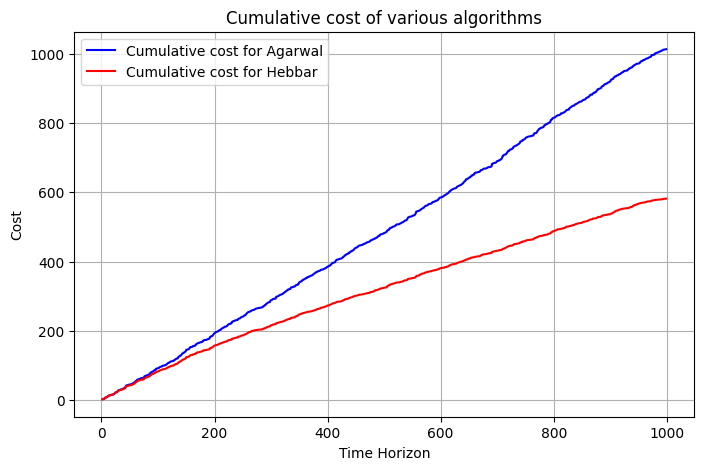

In [136]:
# ---------------------------
# Plotting the optimal values across time
# ---------------------------
# Plot the optimal cumulative cost vs. time horizon
plt.figure(figsize=(8, 5))
Ts = np.arange(2, T)
plt.plot(Ts, cost_A[2:T,0], label="Cumulative cost for Agarwal", color='b')
plt.plot(Ts, cost_H[2:T,0], label="Cumulative cost for Hebbar", color='r')
# plt.plot(Ts, cost_d[2:T,0], label="Cumulative cost w/o input", color='g')
# plt.plot(Ts, cost_FS[2:T,0], label="Cumulative cost - BIH input", color='g')
# plt.plot(Ts, cost_DAC[2:T,0], label="Cumulative cost - BIH DAC", color='o')

# plt.plot(Ts, costs, label='Optimal Feedforward Cumulative Cost', color='g')
# plt.plot(Ts, cumu_cost_until_t[2:T], label="Best in hindsight cost - Fixed state", color='y')
plt.xlabel("Time Horizon")
plt.ylabel("Cost")
plt.title("Cumulative cost of various algorithms")
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(Ts, cumulative_cost_A[2:T]-costs, label="Regret w.r.t constant feedforward - Agarwal", color='b')
# plt.plot(Ts, cumulative_cost_H[2:T]-costs, label="Regret w.r.t constant feedforward - Agarwal", color='r')
# # plt.plot(range(T_aux), optimal_costs(:T_aux), label='Optimal Feedforward Cumulative Cost', color='g')
# plt.xlabel("Time Horizon")
# plt.ylabel("Cost")
# plt.title("Cost of BIH feedforward")
# plt.grid(True)
# plt.show()


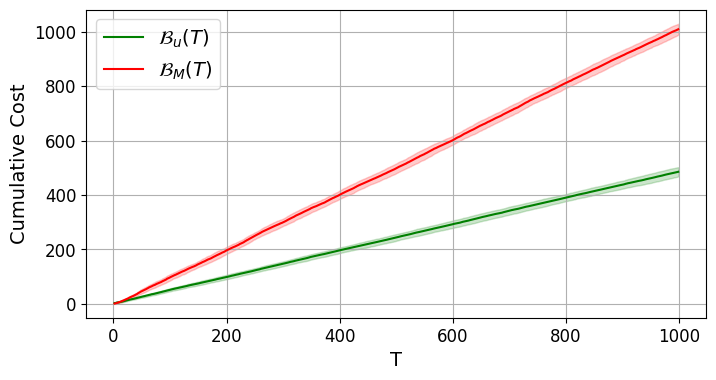

In [163]:
# Skip the first two time steps:
Ts = np.arange(2, T)  # time indices t=2,...,T-1

# Compute average and standard deviation for each algorithm.
avg_cost_A = np.mean(cost_A[2:T, :], axis=1)
std_cost_A = np.std(cost_A[2:T, :], axis=1)

avg_cost_H = np.mean(cost_H[2:T, :], axis=1)
std_cost_H = np.std(cost_H[2:T, :], axis=1)

avg_cost_d = np.mean(cost_d[2:T, :], axis=1)
std_cost_d = np.std(cost_d[2:T, :], axis=1)

avg_cost_FS = np.mean(cost_FS[2:T, :], axis=1)
std_cost_FS = np.std(cost_FS[2:T, :], axis=1)

avg_cost_DAC = np.mean(cost_DAC[2:T, :], axis=1)
std_cost_DAC = np.std(cost_DAC[2:T, :], axis=1)

plt.figure(figsize=(8, 4))
# Plot average cost for Agarwal:
# plt.plot(Ts, avg_cost_A, label="Cumulative cost for Agarwal", color='b')
# plt.fill_between(Ts, avg_cost_A - std_cost_A, avg_cost_A + std_cost_A, color='b', alpha=0.2)

# # Plot average cost for Hebbar:
# plt.plot(Ts, avg_cost_H, label="Cumulative cost for Hebbar", color='r')
# plt.fill_between(Ts, avg_cost_H - std_cost_H, avg_cost_H + std_cost_H, color='r', alpha=0.2)

# Plot average cost for BIH input:
plt.plot(Ts, avg_cost_FS, label=r"$\mathcal{B}_u(T)$", color='g')
plt.fill_between(Ts, avg_cost_FS - std_cost_FS, avg_cost_FS + std_cost_FS, color='g', alpha=0.2)

# Plot average cost for BIH DAC:
plt.plot(Ts, avg_cost_DAC, label=r"$\mathcal{B}_M(T)$", color='r')
plt.fill_between(Ts, avg_cost_DAC - std_cost_DAC, avg_cost_DAC + std_cost_DAC, color='r', alpha=0.2)

plt.xlabel("T", fontsize=14)
plt.ylabel("Cumulative Cost", fontsize=14)
# plt.title("Comparison of Benchmark", fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()

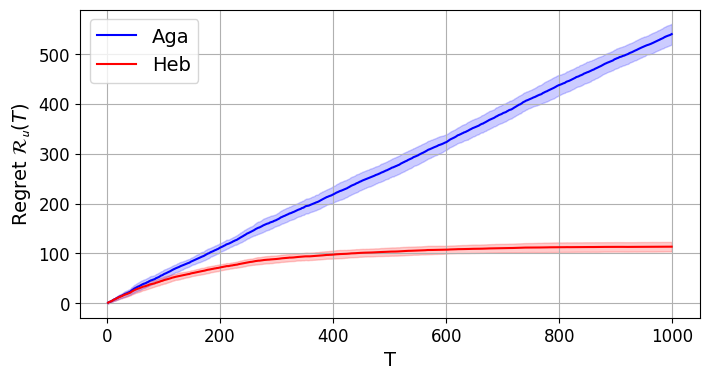

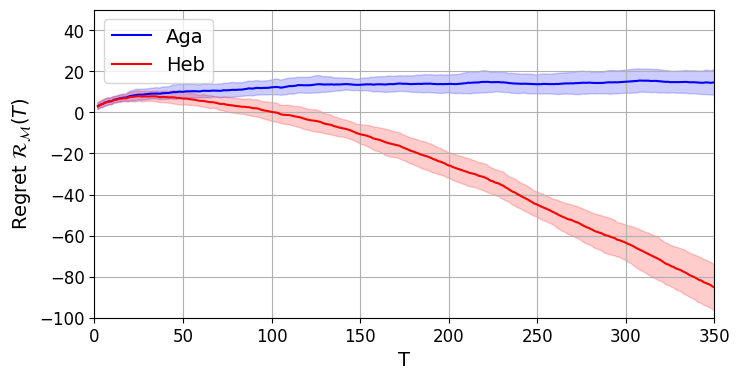

In [164]:
# Compute average and standard deviation for each algorithm with both benchmarks.
Regret_A_FS = cost_A[2:T, :]-cost_FS[2:T, :]
avg_regret_A_FS = np.mean(Regret_A_FS, axis=1)
std_regret_A_FS = np.std(Regret_A_FS, axis=1)

Regret_H_FS = cost_H[2:T, :]-cost_FS[2:T, :]
avg_regret_H_FS = np.mean(Regret_H_FS, axis=1)
std_regret_H_FS = np.std(Regret_H_FS, axis=1)

Regret_A_DAC = cost_A[2:T, :]-cost_DAC[2:T, :]
avg_regret_A_DAC = np.mean(Regret_A_DAC, axis=1)
std_regret_A_DAC = np.std(Regret_A_DAC, axis=1)

Regret_H_DAC = cost_H[2:T, :]-cost_DAC[2:T, :]
avg_regret_H_DAC = np.mean(Regret_H_DAC, axis=1)
std_regret_H_DAC = np.std(Regret_H_DAC, axis=1)

# Regret Bounds.  
# For the regret bound of agarwal et al. we only use the term that compares the DAC policy with best in hindsight DAC policy. In reality
# There are non-negative additive terms that scale as log(T) show up because we are approximating the true cost with the cost of at idealized state.
regret_bd_A = [8*Gc*W*D*dim_x**1.5*kappa**3*H**2.5/gamma*t**0.5 for t in Ts] # This is only a lower bound on the regret bound, beacuse it does not include additional terms.
regret_bd_H = [2*Gc*D/gamma*(2*kappa + (t*(1+kappa**2))**0.5) for t in Ts] # Gc = LD

# Plot avg regret w.r.t. fixed input for both methods. 
plt.figure(figsize=(8, 4))
plt.plot(Ts, avg_regret_A_FS, label="Aga", color='b')
plt.fill_between(Ts, avg_regret_A_FS - std_regret_A_FS, avg_regret_A_FS + std_regret_A_FS, color='b', alpha=0.2)

plt.plot(Ts, avg_regret_H_FS, label="Heb", color='r')
plt.fill_between(Ts, avg_regret_H_FS - std_regret_H_FS, avg_regret_H_FS + std_regret_H_FS, color='r', alpha=0.2)

# Plotting regret bounds by Hebbar
# plt.plot(Ts, regret_bd_H, label="Regret bound by Hebbar", color='g')

plt.xlabel("T",fontsize=14)
plt.ylabel(r"Regret $\mathcal{R}_\mathcal{u}(T)$",fontsize=14)
# plt.title("Regret w.r.t. fixed input",fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# Plot avg regret w.r.t. fixed DAC for both methods. 

plt.figure(figsize=(8, 4))
# Plot avg regret w.r.t. fixed input for both methods. 
plt.plot(Ts, avg_regret_A_DAC, label="Aga", color='b')
plt.fill_between(Ts, avg_regret_A_DAC - std_regret_A_DAC, avg_regret_A_DAC + std_regret_A_DAC, color='b', alpha=0.2)

plt.plot(Ts, avg_regret_H_DAC, label="Heb", color='r')
plt.fill_between(Ts, avg_regret_H_DAC - std_regret_H_DAC, avg_regret_H_DAC + std_regret_H_DAC, color='r', alpha=0.2)

# Plotting regret bounds by Hebbar
# plt.plot(Ts, regret_bd_A, label="Regret bound by Agarwal", color='g')
# plt.plot(Ts, regret_bd_H, label="Regret bound by Agarwal", color='g')

plt.xlabel("T",fontsize=14)
plt.ylabel(r"Regret $\mathcal{R}_\mathcal{M}(T)$",fontsize=14)
plt.xlim([0,350])
plt.ylim([-100,50])
# plt.title("Regret w.r.t DAC policy",fontsize=14)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()


In [88]:
# Just check the norms of the sequence M_list. Sanity check.
for h in range(H):
    print(f'|M_i| = {LA.norm(M_seq[h],2)}, bound by  {kappa * kappa_B * (1 - gamma)**(h)}.')

|M_i| = 0.006651883897089496, bound by  8.386920399869865.
|M_i| = 0.006644092589758658, bound by  2.7956401332899543.
|M_i| = 0.005644491667043001, bound by  0.9318800444299846.
|M_i| = 0.006685869399082196, bound by  0.3106266814766615.
|M_i| = 0.007130527660512893, bound by  0.10354222715888713.
|M_i| = 0.0035947801820041805, bound by  0.034514075719629035.
|M_i| = 0.0036418345898031625, bound by  0.01150469190654301.
|M_i| = 0.0008906046389749843, bound by  0.0038348973021810023.
|M_i| = 0.0003602788918072919, bound by  0.0012782991007270006.
|M_i| = 0.00018832031131224778, bound by  0.0004260997002423334.
|M_i| = 5.572949975969347e-05, bound by  0.0001420332334141111.
|M_i| = 4.5286777628630386e-05, bound by  4.7344411138037026e-05.
|M_i| = 6.235417135556447e-05, bound by  1.578147037934567e-05.


In [95]:
# cost_DAC[2:,0] = np.array(costs)
# cost_DAC[:6,:2]
(2*kappa + (t*(1+kappa**2))**0.5)

np.float64(283.736559844852)

In [94]:
Gc

np.float64(5199.995189419564)